In [1]:
# function plot_pRF_results(initials,numBlock,eyetracker)
# ----------------------------------------------------------------------
# plot_pRF_results(initials,numBlock,eyetracker)
# ----------------------------------------------------------------------
# Goal of the function :
# Compute and plot results from pRF experiment (behavioral and eye tracking
# date
# ----------------------------------------------------------------------
# Input(s) :
# initials : subject initials
# numBlock : number of block to analyse
# eyetracker : eye tracking data
# ----------------------------------------------------------------------
# Output(s):
# => pdf figures /data/xx/pRF_gazeMod/xx_0_results_plot.pdf
# ----------------------------------------------------------------------
# Function created by Martin SZINTE (martin.szinte@gmail.com)
# Last update : 23 / 11 / 2016
# Project :     pRF_gazeMod
# Version :     2.0
# ----------------------------------------------------------------------

In [17]:
def copy_file(srcDir, destDir):
    """
    copy_file copies/renames files to the destination directory. 
    """
    import shutil
    try:
        shutil.copy2(srcDir, destDir)
    except OSError:
        pass
    return None


def extract_start_end_times_beh(timeStart, timeEnd):
    
    # extract start time
    log_fid = glob.glob(os.path.join(source_folder, 'sourcedata', sub_id, 'func', 
                '*_task-{gazeCondition}_run-{tBlock}_log.txt'.format(gazeCondition=gazeCondition, tBlock=tBlock)))
    #print(log_fid)
    with open(log_fid[0]) as f:
        content = f.readlines()
        timeStart.append( float(content[0].split()[-1]) )
        timeEnd.append(   float(content[-1].split()[-1]) )
    
    return timeStart, timeEnd



def extract_first_last_times_eye(msg_file_name, timeStart_eye, timeEnd_eye):
    # get first and last time
    with open(msg_file_name) as f:
        msg_data = f.readlines()


    trialNumbers = []
    firstTime = 0
    for line in msg_data:
        splittedLine = line.split()

        if len(splittedLine) > 5:
            if splittedLine[2] == 'trial':
                if (int(splittedLine[3]) == 0) & (firstTime == 0):
                    timeStart_eye.append( float(splittedLine[1]) )
                    firstTime = 1
                if splittedLine[4] == 'stopped':
                    trialNumbers.append( ( int(splittedLine[3]), float(splittedLine[1]) ) )

    timeEnd_eye.append( max(trialNumbers)[1] )
    
    return timeStart_eye, timeEnd_eye
    
    
    
def import_and_clean_dataset(dat_file_name):
    # col1 = time
    # col2 = eye x coord
    # col3 = eye y coord
    # col4 = pupil size
    with open(dat_file_name) as f:
        eye_data = f.readlines()

    ed         = [data.replace('\t', ' ').replace('\n','').replace('...','') for data in eye_data]
    clean_data = [(float(ed[i].split()[0]), float(ed[i].split()[1]), float(ed[i].split()[2]), float(ed[i].split()[3])) for i in range(len(ed))]
    eye_array = np.array([[coord for coord in xk] for xk in clean_data], ndmin=2)

    return eye_array



def create_dat_msg_files(edf_file, dat_file_name, msg_file_name):

    os.system('edf2asc ' + edf_file + ' -e -y')
    copy_file(edf_file[:-4] + '.asc', msg_file_name)                

    os.system('edf2asc ' + edf_file + ' -s -miss -1.0 -y')
    copy_file(edf_file[:-4] + '.asc', dat_file_name)                

    return None



def read_eyelink_msg_file(msg_file_name, sacc_re = 'ESACC', fix_re = 'EFIX', blink_re = 'EBLINK'):
    """
    read_eyelink_msg_file reads experimental events from the created message file (.msg format, obtaining by using edf2asc and rename .asc into .msg). 
    """
    import re
    
    print('reading eyelink events from', os.path.split(msg_file_name)[-1])
    with open(msg_file_name) as f:
        message_string = f.readlines()

        
    saccade_strings = [msg.replace('\t', ' ').replace('\n', '').replace(sacc_re + ' ', '').split() for msg in message_string if sacc_re  in msg]
    fix_strings     = [msg.replace('\t', ' ').replace('\n', '').replace(fix_re  + ' ', '').split() for msg in message_string if fix_re   in msg]
    blink_strings   = [msg.replace('\t', ' ').replace('\n', '').replace(blink_re+ ' ', '').split() for msg in message_string if blink_re in msg]

    if len(saccade_strings) > 0:
        saccades_from_message_file  = [{'eye':e[0],'start_timestamp':float(e[1]),'end_timestamp':float(e[2]),'duration':float(e[3]),'start_x':float(e[4]),'start_y':float(e[5]),'end_x':float(e[6]),'end_y':float(e[7]), 'length':float(e[8]),'peak_velocity':float(e[9])} for e in saccade_strings]
        fixations_from_message_file = [{'eye':e[0],'start_timestamp':float(e[1]),'end_timestamp':float(e[2]),'duration':float(e[3]),'x':float(e[4]),'y':float(e[5]),'pupil_size':float(e[6])} for e in fix_strings]
        blinks_from_message_file    = [{'eye':e[0],'start_timestamp':float(e[1]),'end_timestamp':float(e[2]),'duration':float(e[3])} for e in blink_strings]

        saccade_type_dictionary = np.dtype([(s , np.array(saccades_from_message_file[0][s]).dtype) for s in saccades_from_message_file[0].keys()])
        fixation_type_dictionary = np.dtype([(s , np.array(fixations_from_message_file[0][s]).dtype) for s in fixations_from_message_file[0].keys()])
        
        if len(blinks_from_message_file) > 0:
            blink_type_dictionary = np.dtype([(s , np.array(blinks_from_message_file[0][s]).dtype) for s in blinks_from_message_file[0].keys()])
    
        return saccades_from_message_file, fixations_from_message_file, blinks_from_message_file


    
def preprocess_data(eye_dict, eye_params, params, show_plots = False):

    eye_operator = EyeSignalOperator(eye_dict, **params) #eye_params['blinks_saccs_in_dict'], 

    # interpolate blinks:
    eye_operator.interpolate_blinks(method = 'linear')
    eye_operator.interpolate_blinks2()

    # low-pass and band-pass pupil data:
    eye_operator.filter_pupil(hp = eye_params['pupil_hp'], lp = eye_params['pupil_lp'])

    # regress blink and saccade responses
    eye_operator.regress_blinks(regress_blinks = eye_params['regress_blinks'], regress_sacs = eye_params['regress_sacs'], regress_xy = eye_params['regress_xy'], 
                                 use_standard_blinksac_kernels = eye_params['use_standard_blinksac_kernels'])

    if show_plots:
        eye_operator.summary_plot()
        fig.show()
    
    # try time-frequency decomposition of the baseline signal
    try:
        eye_operator.time_frequency_decomposition_pupil(
                minimal_frequency = eye_params['minimal_frequency_filterbank'], 
                maximal_frequency = eye_params['maximal_frequency_filterbank'], 
                nr_freq_bins = eye_params['nr_freq_bins_filterbank'], 
                n_cycles = eye_params['n_cycles_filterbank'], 
                cycle_buffer = eye_params['cycle_buffer_filterbank'],
                tf_decomposition = eye_params['tf_decomposition_filterbank'],
                )
        print('Performed T-F analysis of type %s'% eye_operator['tf_decomposition_filterbank'])
        for freq in eye_operator.band_pass_filter_bank_pupil.keys():
            bdf['pupil_filterbank_bp_%2.5f'%freq] = eye_operator.band_pass_filter_bank_pupil[freq]
            print('Saved T-F analysis %2.5f'%freq)
    except:
        print('Something went wrong with T-F analysis of type {0}'.format(eye_params['tf_decomposition_filterbank']))
    pass


    return eye_operator



def add_eye_data_to_df(eye_dat, eye_operator, eye_params):
    bdf = pd.DataFrame(eye_dat[:,0], columns = ['timepoints'])
    
    # add to existing dataframe:
    bdf['interpolated_timepoints'] = eye_operator.interpolated_time_points
    bdf['pupil_int'] = eye_operator.interpolated_pupil
    bdf['pupil_hp'] = eye_operator.hp_filt_pupil
    bdf['pupil_baseline'] = eye_operator.baseline_filt_pupil
    bdf['gaze_x_int'] = eye_operator.interpolated_x
    bdf['gaze_y_int'] = eye_operator.interpolated_y

    bdf['pupil_lp'] = eye_operator.lp_filt_pupil
    bdf['pupil_lp_clean'] = eye_operator.lp_filt_pupil_clean

    bdf['pupil_bp'] = eye_operator.bp_filt_pupil
    bdf['pupil_bp_clean'] = eye_operator.bp_filt_pupil_clean

    # add normalized timeseries:
    if eye_params['normalization'] == 'zscore':
        eye_operator.zscore_pupil(dtype='lp_filt_pupil')
        eye_operator.zscore_pupil(dtype='lp_filt_pupil_clean')
        eye_operator.zscore_pupil(dtype='bp_filt_pupil')
        eye_operator.zscore_pupil(dtype='bp_filt_pupil_clean')
        bdf['pupil_lp_zscore'] = eye_operator.lp_filt_pupil_zscore
        bdf['pupil_lp_clean_zscore'] = eye_operator.lp_filt_pupil_clean_zscore
        bdf['pupil_bp_zscore'] = eye_operator.bp_filt_pupil_zscore
        bdf['pupil_bp_clean_zscore'] = eye_operator.bp_filt_pupil_clean_zscore
    
    if eye_params['normalization'] == 'psc':
        eye_operator.percent_signal_change_pupil(dtype='lp_filt_pupil')
        eye_operator.percent_signal_change_pupil(dtype='lp_filt_pupil_clean')
        eye_operator.percent_signal_change_pupil(dtype='bp_filt_pupil')
        eye_operator.percent_signal_change_pupil(dtype='bp_filt_pupil_clean')
        bdf['pupil_lp_psc'] = eye_operator.lp_filt_pupil_psc
        bdf['pupil_lp_clean_psc'] = eye_operator.lp_filt_pupil_clean_psc
        bdf['pupil_bp_psc'] = eye_operator.bp_filt_pupil_psc
        bdf['pupil_bp_clean_psc'] = eye_operator.bp_filt_pupil_clean_psc

    return bdf

In [18]:
% matplotlib inline
import matplotlib as plt
import os
import pandas as pd
#from hedfpy import EyeSignalOperator
from pRF_gazeMod.hedfpy import EyeSignalOperator

import os, glob, shutil
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import json


# Define analysis parameters
# --------------------------
with open('analysis_settings.json') as f:                                                                   # get main analysis settings
    json_s                          =   f.read()
    analysis_info                   =   json.loads(json_s)


# Visualization
TR = analysis_info['TR']
Hz = analysis_info['eye_sampling_rate']
secondsPerSample = (1000 / Hz) / 1000
samplesPerTR = int(np.ceil( TR / secondsPerSample ))
seconds_rolling_window = 5


# Initializing
x_screen_resolution = 1920
y_screen_resolution = 1080
pixel_per_deg = 108

sub_id = 'sub-002'
gazeConditions = ['gazeRight', 'gazeLeft']
time_lastBlock = 0
numBlock = 4

# Laptop
source_folder = '/Users/pRF_gazeMod/'
project_folder = '/Users/pRF_gazeMod/derivatives/pp/{sub_id}/'.format(sub_id = sub_id)

# Aeneas
source_folder = '/home/pRF_gazeMod/'
project_folder = '/home/pRF_gazeMod/derivatives/pp/{sub_id}/'.format(sub_id = sub_id)

zoomVal = 1
time_lastBlock = 0
eye_data_allblock = []
fixAccuracy = []
timeStart_eye = []
timeEnd_eye = []
eye_dfs = []

eye_params = dict(
                alias = None, 
                which_eye = 0, 
                pupil_hp = 0.01, 
                pupil_lp = 6.0,
                sample_rate = 1000.,
                normalization = 'psc',
                blinks_saccs_in_dict = True,
                regress_blinks = True,
                regress_sacs = False,
                regress_xy = False, 
                use_standard_blinksac_kernels = True,
                minimal_frequency_filterbank = 0.0025, 
                maximal_frequency_filterbank = 0.1, 
                nr_freq_bins_filterbank = 9, 
                n_cycles_filterbank = 1, 
                cycle_buffer_filterbank = 3,
                tf_decomposition_filterbank ='lp_butterworth' 
                )


gazeLeft_list = [gazeConditions[0]] * numBlock
gazeRight_list = [gazeConditions[1]] * numBlock

gazeConditions_combined = [item for pair in zip(gazeLeft_list, gazeRight_list) for item in pair]
block_list = [item for pair in zip( np.arange(1, numBlock + 1), np.arange(1, numBlock + 1)) for item in pair]


# Creating eye_data folder in the derivatives folder if it doesn't exist yet
data_folder = os.path.join(project_folder, 'eye_data')
try:
    os.mkdir(data_folder)
except OSError: pass


    

## Get data
## ---------

print('\nProcessing data...\n')
timeStart = []
timeEnd = []


## Indexing does not work with zip (as run numbers will be repeated)
index = 0
for tBlock in np.arange(1, numBlock + 1):
    
    for gazeCondition in gazeConditions:

        # get starting and ending times of the behavioural log file
        timeStart, timeEnd = extract_start_end_times_beh(timeStart, timeEnd)

        ## Get eye data
        ## ------------
        # extract data file
        dat_file_name = os.path.join(data_folder,'{sub_id}_task-{gazeCondition}_run-{tBlock}_eyedata.dat'.format(sub_id=sub_id, gazeCondition=gazeCondition, tBlock=tBlock))
        msg_file_name = dat_file_name[:-4] + '.msg'
        dat_file = glob.glob(dat_file_name)
        msg_file = glob.glob(msg_file_name)

        # create .msg and .dat file if they do not exist yet
        if (not dat_file) | (not msg_file):
            edf_file = glob.glob(os.path.join(source_folder, 'sourcedata', sub_id, 'func', 
                        '*_task-{gazeCondition}_run-{tBlock}_eyedata.edf'.format(gazeCondition=gazeCondition, tBlock=tBlock)))[0]

            create_dat_msg_files(edf_file, dat_file_name, msg_file_name)

        # extract the starting and ending times of the individual blocks saved in the eyelink .msg file
        timeStart_eye, timeEnd_eye = extract_first_last_times_eye(msg_file_name, timeStart_eye, timeEnd_eye)

        # import eyelink data and clean it
        eye_array = import_and_clean_dataset(dat_file_name)

        # take trial starts/endings from .msg file to only select relevant data
        eye_dat = eye_array[(eye_array[:,0] >= timeStart_eye[index]) & (eye_array[:,0] <= timeEnd_eye[index])]
        
        
        # compute time relative to start of trial and across blocks
        eye_dat[:,0] = eye_dat[:,0] - timeStart_eye[index] + time_lastBlock
        time_lastBlock = eye_dat[-1,0]

        # extract eyelink information about saccades, fixations and blinks
        saccades, fixations, blinks = read_eyelink_msg_file(msg_file_name)


        eye_dict = {
                'timepoints': eye_dat[:,0],
                'gaze_X':     eye_dat[:,1],
                'gaze_Y':     eye_dat[:,2],
                'pupil':      eye_dat[:,3]
                    }
        params =   {
                    'sample_rate': 500.0,
                    'eyelink_blink_data': pd.DataFrame(blinks),
                    'eyelink_sac_data': pd.DataFrame(saccades) 
                    }

        eye_operator = preprocess_data(eye_dict, eye_params, params, show_plots = False) # returns eye operator

        if tBlock == 1:
            df_overall = add_eye_data_to_df(eye_dat, eye_operator, eye_params) # returns pandas dataframe
        else:
            df_run = add_eye_data_to_df(eye_dat, eye_operator, eye_params) # returns pandas dataframe
            dataframes = [df_overall, df_run]
            df_overall = pd.concat(dataframes)
        index += 1

print('\nProcessing finished.\n')


Processing data...

reading eyelink events from sub-002_task-gazeRight_run-1_eyedata.msg
18-06-12_20-17-18 - INFO - EyeSignalOperator - Interpolating blinks using interpolate_blinks
18-06-12_20-17-18 - INFO - EyeSignalOperator - Band-pass filtering of pupil signals, hp = 0.010, lp = 6.000
18-06-12_20-17-18 - INFO - EyeSignalOperator - Regressing blinks, saccades and gaze position of pupil signals
[(218464,)]
18-06-12_20-17-18 - INFO - EyeSignalOperator - Nuisance GLM Results, pearsons R (p) is 0.222 (0.0000)
18-06-12_20-17-18 - INFO - EyeSignalOperator - Nuisance GLM Results, blink beta 345.93684791478836
18-06-12_20-17-18 - INFO - EyeSignalOperator - Time_frequency_decomposition_pupil, with filterbank [ 0.1         0.06305834  0.03976354  0.02507422  0.01581139  0.0099704
  0.00628717  0.00396458  0.0025    ]
Something went wrong with T-F analysis of type lp_butterworth
reading eyelink events from sub-002_task-gazeLeft_run-1_eyedata.msg
18-06-12_20-17-19 - INFO - EyeSignalOperator - 

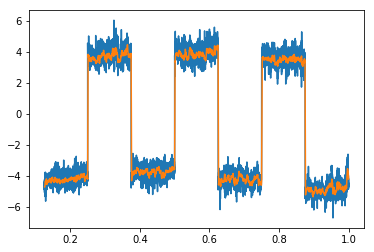

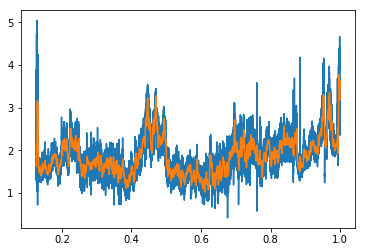

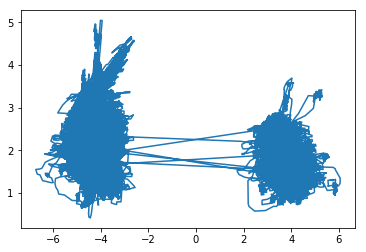

In [26]:
seconds_rolling_window = 5

# compute in time percentage between start and end
df_overall['absolute_timepoints'] = df_overall.timepoints
df_overall['timepoints'] = df_overall['timepoints'] / df_overall['timepoints'].max()

# put eye coordinates in deg from center (flip y axis)
df_overall['gaze_x_deg'] = (df_overall['gaze_x_int'] - x_screen_resolution / 2) / pixel_per_deg
df_overall['gaze_y_deg'] = (-1.0 * (df_overall['gaze_y_int'] - y_screen_resolution / 2)) / pixel_per_deg

# Creating the rolling mean values
df_overall['rolling_mean_x'] = pd.rolling_mean( df_overall.gaze_x_deg, window = samplesPerTR * seconds_rolling_window )
df_overall['rolling_mean_y'] = pd.rolling_mean( df_overall.gaze_y_deg, window = samplesPerTR * seconds_rolling_window )



# plot
plt.plot(df_overall.timepoints, df_overall.gaze_x_deg)
plt.plot(df_overall.timepoints, df_overall.rolling_mean_x)
plt.show()

plt.plot(df_overall.timepoints, df_overall.gaze_y_deg)
plt.plot(df_overall.timepoints, df_overall.rolling_mean_y)
plt.show()

plt.plot(df_overall.gaze_x_deg, df_overall.gaze_y_deg)
plt.show()


In [21]:
## Hexbin
## ------
# An attempt of creating a KDE plot with Bokeh
import numpy as np
from bokeh.io import output_file, show
from bokeh.models import HoverTool
from bokeh.plotting import figure

n = df_overall.shape[0]
x = df_overall.gaze_x_deg
y = df_overall.gaze_y_deg

p = figure(title="Hexbin for 500 points", match_aspect=True,
           tools="wheel_zoom,reset", background_fill_color='#440154')
p.grid.visible = False

r, bins = p.hexbin(x, y, size=0.05, hover_color="pink", hover_alpha=0.8)

output_file("hexbin.html")

show(p)

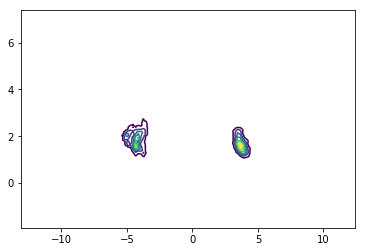

In [23]:
import numpy as np
from fastkde import fastKDE
import pylab as PP

## Creating contours
## -----------------

#Do the self-consistent density estimate
myPDF,axes = fastKDE.pdf(m1, m2)

#Extract the axes from the axis list
v1,v2 = axes

#Plot contours of the PDF
PP.contour(v1,v2,myPDF)
PP.show()